In [1]:
%load_ext autoreload
%autoreload 2

import os, errno

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline

import glam as gb

In [2]:
np.random.seed(1)

In [3]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [4]:
make_sure_path_exists('examples/example_1/figures/')
make_sure_path_exists('examples/example_1/results/in_sample/traces/')
make_sure_path_exists('examples/example_1/results/in_sample/model_comparison/')
make_sure_path_exists('examples/example_1/results/out_of_sample/traces/')
make_sure_path_exists('examples/example_1/results/out_of_sample/predictions/')

# Example 1: Explore individual gaze biases

The first example is based on a study by Thomas et al. (2019). Here, the authors study the association between gaze allocation and choice behaviour on the level of the individual. Particularly, the authors explore whether (1) an association between gaze and choice is present at the individual level and (2) the strength of this association varies between individuals.

## Simulating data

First, we simulate a dataset of 30 subjects, each performning 200 simple value-based choice trials. We assume that in each trial participants are asked to choose the item that they like most out of a set of four presented alternatives (similar to the task described in Towal, Moorman & Koch, 2013). While participants perform the task, their eye movements, choices and response times are measured. After completing all choice trials, participants further indicate their liking rating for each of the items presented in the choice task on a liking rating scale from 1 to 10 (with 10 indicating strong liking and 1 indicating little liking). The resulting datasets contains a liking value for each choice item in each trial, the participants' choice and response, as well as their aggregated gaze data (describing the fraction of trial time that they spent looking at each item in the choice set).

In [5]:
n_subjects = 30
subjects = np.arange(n_subjects)
n_trials = 200
n_items = 4

To simulate individuals' choice behaviour, we define a set of generating model parameters for each individual. We assume that these parameters are drawn independently for each subject from uniform distributions (with lower and upper bound; based on the parameter estimates obtained in Thomas et al., 2019):

* v ~ U(2e-5,2e-4) 
* $\sigma$ ~ U(0.002,0.02) 
* $\gamma$ ~ U(-1,0.5) 
* $\tau$ ~ U(0.5,5)

Importantly, we further assume that five subjects do not exhibit a gaze bias (i.e., that their choices are independent of the time that they spend looking at each item). To this end, we will set the $\gamma$ parameter for five randomly selected subjects to 1. We further also assume that individuals’ gaze is distributed randomly with respect to the values of the items in a choice set. 

In [6]:
# generating model parameters
gen_v = np.random.uniform(2e-5, 2e-4, size=n_subjects)
gen_SNR = np.random.uniform(10,50,size=n_subjects)
gen_sigma = gen_SNR * gen_v #np.random.uniform(0.002, 0.02, size=n_subjects)
gen_tau = np.random.uniform(0.5,5,n_subjects)
gen_t0 = np.zeros(n_subjects)
gen_gamma = np.random.uniform(-1, 0.5, n_subjects)
# define subjects with no association between gaze and choice:
no_gaze_bias_subjects = np.sort(np.random.choice(n_subjects, 5, replace=False))
gaze_bias_subjects = np.array([s for s in subjects if s not in no_gaze_bias_subjects])
gen_gamma[no_gaze_bias_subjects] = 1


# create a dictionary containing all generating parameters
gen_parameters = dict(v=gen_v,
                      gamma=gen_gamma,
                      s=gen_sigma,
                      t0=gen_t0,
                      tau=gen_tau)

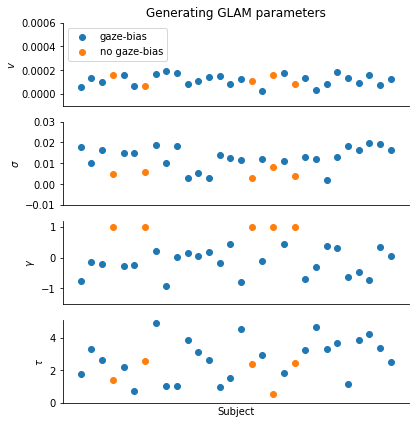

In [7]:
# overview of the distribution of generating parameters

fig, axs = plt.subplots(4, 1, figsize=(6,6), sharex=True)

for subject_set, color, label in zip([gaze_bias_subjects,
                                      no_gaze_bias_subjects],
                                      ['C0', 'C1'],
                                      ['gaze-bias', 'no gaze-bias']):
    # v
    axs[0].scatter(subject_set,
                   gen_v[subject_set],
                   label=label,
                   color=color)
    axs[0].set_ylabel(r'$v$')
    axs[0].set_xticks([])
    
    # sigma
    axs[1].scatter(subject_set,
                   gen_sigma[subject_set],
                   color=color)
    axs[1].set_ylabel(r'$\sigma$')
    axs[1].set_xticks([])

    # gamma
    axs[2].scatter(subject_set,
                   gen_gamma[subject_set],
                   color=color)
    axs[2].set_ylabel(r'$\gamma$')
    axs[2].set_xticks([])

    # tau
    axs[3].scatter(subject_set,
                   gen_tau[subject_set],
                   color=color)
    axs[3].set_ylabel(r'$\tau$')
    axs[3].set_xlabel('Subject')
    axs[3].set_xticks([])

axs[0].set_title('Generating GLAM parameters')
axs[0].set_ylim(-0.0001, 0.0006)
axs[1].set_ylim(-0.01, 0.03)
axs[2].set_ylim(-1.5, 1.2)
axs[3].set_ylim(0, 5.1)
axs[0].legend(loc='upper left')
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('examples/example_1/figures/Supplementary_Figure_1_generating_parameters.png', dpi=330)

Subjects with no association of gaze allocation and choice behaviour:

In [8]:
no_gaze_bias_subjects

array([ 3,  6, 16, 18, 20])

To simulate individuals' response behaviour, we use the *simulate_group* method of the GLAM model class. This function requires us to specify whether the individuals of this group are either simulated as individuals (and thereby independent of one another) or as part of a hierarchical parameter distribution (where the individual model parameters are drawn from a group distribution). If we specify the group as individual, the generating parameters need to be provided as a dictionary, containing one entry per parameter, containing an array of parameter values. 

In [9]:
glam = gb.GLAM() # create GLAM model instance
glam.simulate_group(kind='individual',
                    n_individuals=n_subjects,
                    n_trials=n_trials,
                    n_items=n_items,
                    parameters=gen_parameters,
                    value_range=(1, 10))

We can then access the simulated data as part of our glam model instance.

In [10]:
data = glam.data.copy()

As this example is focussed on the individual level, we further create a summary dataframe, describing individuals' response behaviour on three behavioural metrics (as described in Thomas et al., 2019). Namely, individuals' mean response time, probability of choosing the item with the highest liking rating from a choice set and a behavioural measure of the strength of the association between gaze allocation and choice behaviour (indicating the mean increase in choice probability for an item that was looked at longer than the others, after correcting for the inﬂuence of item value on choice probability; for further details on the behavioural gaze bias measure, see Thomas et al., 2019).

In [11]:
subject_data_summary = gb.analysis.aggregate_subject_level_data(data, n_items)

/Users/armin/anaconda3/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.6.0 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [12]:
subject_data_summary.head()

best_chosen        rt                                                \
               mean      mean         std    min     max         se      q1   
subject                                                                       
0.0           0.280  1387.275  908.403335  293.0  4878.0  64.395005  716.75   
1.0           0.515   974.490  631.810019  332.0  4836.0  44.787825  639.00   
2.0           0.395  1067.425  642.967429   36.0  4558.0  45.578753  628.75   
3.0           0.955   872.040  482.200123   77.0  4269.0  34.182260  627.50   
4.0           0.410   824.780  488.594670  292.0  3539.0  34.635558  549.25   

                          gaze_influence  
              q3      iqr                 
subject                                   
0.0      1817.00  1100.25       0.154371  
1.0      1047.50   408.50       0.413887  
2.0      1299.25   670.50       0.314483  
3.0       986.00   358.50      -0.029167  
4.0       954.25   405.00       0.395949

## Explore behavioural data 

In a first step of our analysis, we explore differences in individuals' response behaviour on these three behavioural metrics. To create an overview of the distribution of individuals' values on the metrics, as well as the associations between them, we make use of the *individual_differences* function implemented in the GLAMbox plots module.

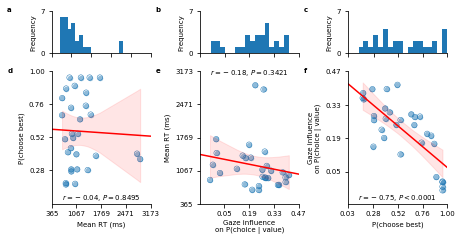

In [13]:
fig = gb.plots.individual_differences(subject_summary=subject_data_summary,
                                      regression=True,
                                      annotate=True)
fig.savefig('examples/example_1/figures/Figure_1_individual_differences.png', dpi=330)

We find that most individuals exhibit a positive association of gaze allocation and choice behaviour, as indicated by the behavioural gaze bias measure (b).

Further, we find that both, individuals' probability of choosing the best item and behavioural gaze bias, are not associated with their respose times. Interestingly, however, individuals' probability of choosing the best item from a choice set increases with decreasing strength of the behavioural gaze bias. Individuals with a strong association of gaze allocation and choice behaviour (as indicated by high values on the behavioural gaze bias measure) are therefore less likely to choose the item with the highest value from a choice set, when compared to individuals with a weak association of gaze and choice.

## Individual Model Comparison

### Relative Model Fit

In a second step of our analysis, we want to test whether the response behaviour of each individual in the data is better described by a GLAM variant with or without gaze bias (i.e., a variant in which the gaze bias parameter is fixed to 1). To this end, we set up both model instances:

In [14]:
gaze_bias_model = gb.GLAM(data)
gaze_bias_model.make_model(kind='individual', verbose=False)

no_gaze_bias_model = gb.GLAM(data=data)
no_gaze_bias_model.make_model(kind='individual', gamma_val=1, verbose=False)

Subsequently, we fit both of model variants to the data of each individual and compare their fit by means of the Widely Applicable Information Criterion (WAIC; Vehtari, Gelman, & Gabry, 2017). To fit each model, we utilize an MCMC sampling procedure with the Metropolis-Hastings algorithm (XXX). For each model and parameter, we sample four chains. Each chain contains 10000 tuning samples (that we discard) and another 10000 samples that we use to determine individuals' parameter estimates. All resulting parameter traces were checked for convergence, before performing the model comparison. We establish convergence for a trace if the Rhat measure (XXX) is between 0.95 and 1.05 or the trace contains at least 100 effective samples (XXX). All parameter traces were further check for convergence by visual inspection.

In [15]:
method='MCMC'
ndraws = 5000
ntune = 20000
nchains = 4 # we sample four chains per parameter
ncores = 4 # each chain is sampled independently on a dedicated core

In [16]:
gaze_bias_model.fit(method=method,
                    tune=ntune,
                    draws=ndraws,
                    chains=nchains,
                    cores=ncores,
                    progressbar=False,
                    verbose=False)

ValueError: Not enough samples to build a trace.

In [ ]:
no_gaze_bias_model.fit(method=method,
                       tune=ntune,
                       draws=ndraws,
                       chains=nchains,
                       cores=ncores,
                       progressbar=False,
                       verbose=False) 

Convergence check:

In [ ]:
def check_convergence(summary, varnames=['v', 's', 'tau'],
                      n_eff_required=100, gelman_rubin_criterion=0.05):
    varnames = [varname + '__0_0' for varname in varnames]
    enough_eff_samples = np.all(summary.loc[varnames]['n_eff'] > n_eff_required)
    good_gelman = np.all(np.abs(summary.loc[varnames]['Rhat'] - 1.0) < gelman_rubin_criterion)
    if not enough_eff_samples or not good_gelman:
        return False
    else:
        return True

In [ ]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau']) for trace in gaze_bias_model.trace])

In [ ]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau']) for trace in no_gaze_bias_model.trace])

Saving traces and traceplots for visual inspection:

In [22]:
for subject, subject_trace in enumerate(gaze_bias_model.trace):
    pm.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

In [23]:
for subject, subject_trace in enumerate(no_gaze_bias_model.trace):
    pm.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/in_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

After convergence has been established for each trace, we can perform a model comparison on the individual level. For this comparison, we utilize the *compare* function of the PyMC3 library.

In [24]:
dWAIC = np.array([])
for subject in tqdm(subjects):
    waic_df = pm.compare({gaze_bias_model.model[subject]: gaze_bias_model.trace[subject],
                          no_gaze_bias_model.model[subject]: no_gaze_bias_model.trace[subject]},
                          ic='WAIC') 
    # pm.compare indexes models in waic_df by the order in which they were entered
    # we entered the model with gaze bias first, it therefore has index 0 in waic_df
    if waic_df.index.values[0] == 0:
        # model with gaze bias is best fitting
        dWAIC = np.append(dWAIC, -1 * waic_df.loc[1, 'dWAIC'])
    else:
        # model without gaze bias is best fitting
        dWAIC = np.append(dWAIC, waic_df.loc[0, 'dWAIC'])
np.save('examples/example_1/results/in_sample/model_comparison/dWAIC_in_sample.npy', dWAIC)

 40%|████      | 12/30 [02:38<03:51, 12.89s/it]/Users/armin/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
 83%|████████▎ | 25/30 [05:23<01:04, 12.82s/it]/Users/armin/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
 87%|████████▋ | 26/30 [05:36<00:51, 12.92s/it]/Users/armin/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see h

In [25]:
# identify subjects better described by each model variant
gaze_bias_idx = dWAIC < 0
no_gaze_bias_idx = dWAIC > 0

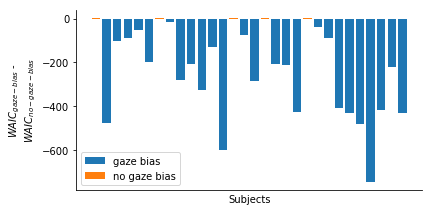

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6,3),dpi=330)

ax.bar(subjects[gaze_bias_idx], dWAIC[gaze_bias_idx], color='C0', label='gaze bias')
ax.bar(subjects[no_gaze_bias_idx], dWAIC[no_gaze_bias_idx], color='C1', label='no gaze bias')
ax.set_xlabel('Subjects')
ax.set_ylabel(r'$WAIC_{gaze-bias}$'+' -\n'+r'$WAIC_{no-gaze-bias}$')
ax.legend()
ax.set_xticks([])
ax.tick_params(axis='both', which='major')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fig.savefig('examples/example_1/figures/Figure_1_relative_model_comparison.png', dpi=330)

We find that all subjects, except for those which we defined as not having a gaze bias, are better described by a GLAM variant with gaze bias than by one without (as indicated by a lower WAIC score). 

In [27]:
subjects[no_gaze_bias_idx]

array([ 0,  6, 13, 16, 20])

When looking at the individual parameter estimates (defined as maximum-a-priori or MAP of the GLAM's posterior traces), we find that the individually fitted $\gamma$ values (see Fig. XX) cover a wide range between XX and XX. We also find that $\gamma$ estimates are strongly correlated with individuals’ values on the behavioural gaze bias measure (see Fig. XX). Thereby, indicating that the strength of the association between individuals’ gaze allocation and choice behaviour strongly varies between individuals. 

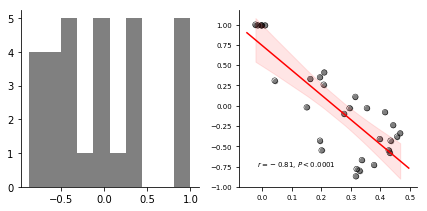

In [40]:
fig, axs = plt.subplots(1,2,figsize=(6,3),dpi=330)

axs[0].hist(gaze_bias_model.estimates['gamma'],
            bins=np.linspace(-1,0.5,20))
gb.plots.plot_correlation(subject_data_summary['gaze_influence'],
                          gaze_bias_model.estimates['gamma'],
                          ax=axs[1])

axs[0].set_ylabel('Frequency')
axs[0].set_xlabel(r'$\gamma$')
axs[1].set_ylabel(r'$\gamma$')
axs[1].set_xlabel('Gaze influence on P(choice | value)')
fig.tight_layout()
fig.savefig('examples/example_1/figures/Figure_2_gaze_bias_estimates.png', dpi=330)

### Absolute Model Fit

Our likelihood-based model comparison has indiciated whether the response behaviour of each individual in the data is better described by a GLAM variant with or without gaze bias. Yet, it did not indicate whether the GLAM also represents a good model of their response behaviour on an absolute level. To test this, we further perform an out-of-sample prediction exersice.

First, we divide the data of each subject into the even- and odd-numbered experiment trials:

In [29]:
data_even = data[(data['trial']%2)==0].copy()
data_odd = data[(data['trial']%2)!=0].copy()

We then use the data of the even-numbered trials to fit both GLAM variants:

In [30]:
gaze_bias_model = gb.GLAM(data=data_even)
gaze_bias_model.make_model(kind='individual')

no_gaze_bias_model = gb.GLAM(data=data_even)
no_gaze_bias_model.make_model(kind='individual', gamma_val=1)

Generating single subject models for 30 subjects...
Generating single subject models for 30 subjects...


In [31]:
gaze_bias_model.fit(method=method,
                    tune=ntune,
                    draws=ndraws,
                    chains=nchains,
                    cores=ncores,
                    progressbar=False,
                    verbose=False)

/!\ Automatically setting parameter precision...


In [32]:
no_gaze_bias_model.fit(method=method,
                       tune=ntune,
                       draws=ndraws,
                       chains=nchains,
                       cores=ncores,
                       progressbar=False,
                       verbose=False)

/!\ Automatically setting parameter precision...


Again, we check all parameter traces for convergence, before preceeding further in the anlaysis:

In [33]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'gamma', 'tau']) for trace in gaze_bias_model.trace])

True

In [34]:
np.all([check_convergence(pm.summary(trace), varnames=['v', 's', 'tau']) for trace in no_gaze_bias_model.trace])

False

In [35]:
for subject, subject_trace in enumerate(gaze_bias_model.trace):
    pm.traceplot(subject_trace)
    plt.savefig('examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_gaze_bias_model_trace.csv'.format(subject))

FileNotFoundError: [Errno 2] No such file or directory: 'examples/example_1/figures/traceplots/out_of_sample/sub_0_no_gaze_bias_model_trace.png'

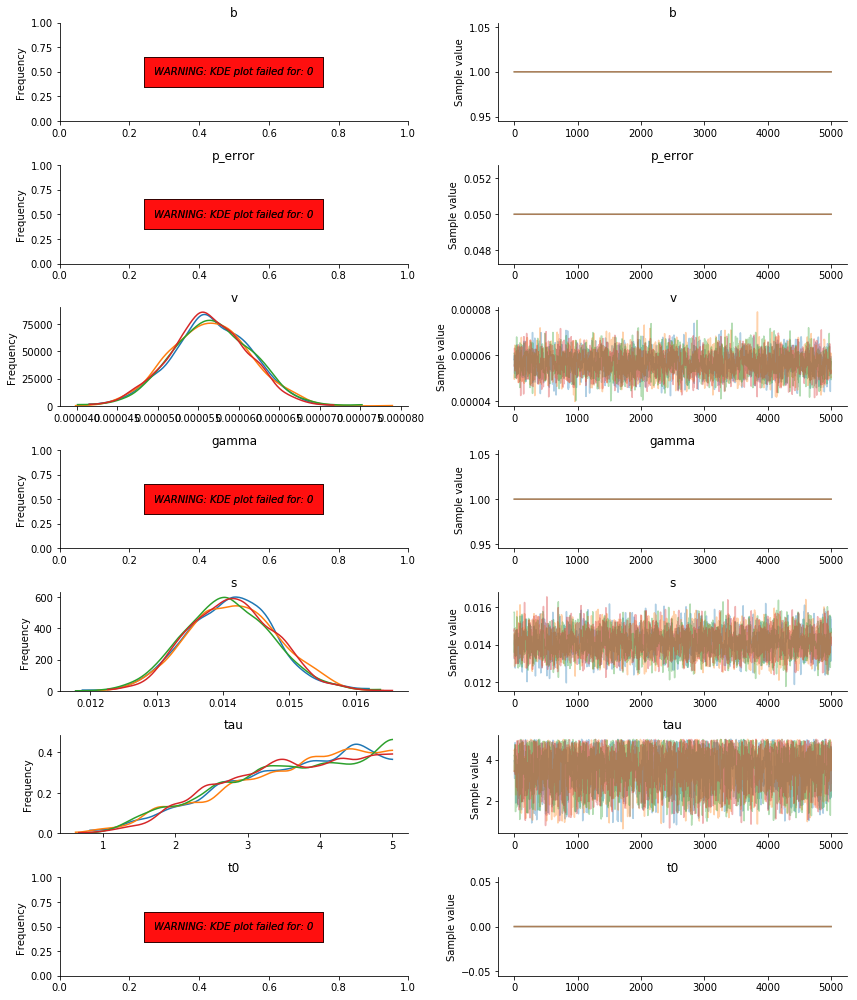

In [44]:
for subject, subject_trace in enumerate(no_gaze_bias_model.trace):
    pm.traceplot(subject_trace)
    plt.savefig('examples/example_1/figures/traceplots/out_of_sample/sub_{}_no_gaze_bias_model_trace.png'.format(subject), dpi=330)
    plt.close()
    pm.trace_to_dataframe(subject_trace).to_csv(
        'examples/example_1/results/out_of_sample/traces/sub_{}_no_gaze_bias_model_trace.csv'.format(subject))

After establishing convergence of all parameter traces, we utilize the individually estimated models to predict choices and response times for each trial in the held-out dataset (containing all odd-numbered experiment trials). In this simulation, we repeat each trial 50 times in order to gain a stable estimate of the GLAM's response behaviour:

In [ ]:
n_repeats = 50

In [ ]:
# we exchange the data of the even-numbered trials with the data of the odd-nmbered trials
gaze_bias_model.exchange_data(data_odd)
no_gaze_bias_model.exchange_data(data_odd)

In [ ]:
gaze_bias_model.predict(n_repeats=n_repeats)
gaze_bias_pred = gaze_bias_model.prediction
gaze_bias_pred.to_csv('examples/example_1/results/out_of_sample/predictions/gaze_bias_model_predictions.csv')

In [ ]:
no_gaze_bias_model.predict(n_repeats=n_repeats)
no_gaze_bias_pred = no_gaze_bias_model.prediction
no_gaze_bias_pred.to_csv('examples/example_1/results/out_of_sample/predictions/no_gaze_bias_model_predictions.csv')

Again, we aggregate the predictions of both model variants on the individual level by the use of the *aggregate_subject_level_data* function:

In [ ]:
gaze_bias_pred_subject_summary = gb.aggregate_subject_level_data(gaze_bias_pred, n_items)
print(gaze_bias_pred_subject_summary.head())

In [ ]:
no_gaze_bias_pred_subject_summary = gb.aggregate_subject_level_data(no_gaze_bias_pred, n_items)
print(no_gaze_bias_pred_subject_summary.head())

To then determine the absolute fit of both model variants to the data, we plot the individually predited against the individually observed data on our three behavioural metrics. To do this, we utilize the *absolute_fit_individual* function of the plots module. This function takes as input the subject-level summary of the observed data, as well as a list of the subject-level summaries of the predictions of all model variants that are to be compared. For each model variant, the function creates a new row of panels, plotting the observed against the predicted data.

In [ ]:
fig = gb.plots.absolute_fit_individual(observed=aggregate_subject_level_data(data_odd, n_items),
                                       predictions=[gaze_bias_pred_subject_summary,
                                                    no_gaze_bias_pred_subject_summary],
                                       prediction_labels=['gaze-bias', 'no gaze-bias'])
fig.savefig('examples/example_1/figures/Figure_3_absolute_fit.png', dpi=330)

Both model variants perform well in capturing individuals' response times and probability of choosing the best item. Yet, only the GLAM variant with gaze bias is able to also recover the strength of the association between individuals' choice behaviour and gaze allocation.

## Association between model parameters and behaviour

In the last step of our analysis, we want to test whether the individual GLAM parameter estimates from the even-numbered experiment trials are able to predict individuals' response characteristics on the three behavioural metrics in the odd-numbered trials. To this end, we plot each set of parameter against each behavioural metric.

In [ ]:
fig, axs = plt.subplots(4,3, figsize=gb.plots.cm2inch(18,18))


subject_data_summary_odd = aggregate_subject_level_data(data_odd, n_items)
for i, parameter in enumerate(['v', 'sigma', 'gamma', 'tau']): 
    
    # response time
    gb.plots.plot_correlation(gaze_bias_model.paramaters[paramater],
                              subject_data_summary_odd['rt']['mean'],
                              ax=axs[i,0])
    axs[i,0].set_xlabel(r'$\{}$'.format(parameter), fontsize=8)
    axs[i,0].set_ylabel('Response time (ms)', fontsize=8)
    
    # P(choose item | value)
    gb.plots.plot_correlation(gaze_bias_model.paramaters[paramater],
                              subject_data_summary_odd['best_chosen']['mean'],
                              ax=axs[i,1])
    axs[i,1].set_xlabel(r'$\{}$'.format(parameter), fontsize=8)
    axs[i,1].set_ylabel('P(choose item | value)', fontsize=8)
    
    # Gaze influence on P(choose item | value)
    gb.plots.plot_correlation(gaze_bias_model.paramaters[paramater],
                              subject_data_summary_odd['gaze_influence'],
                              ax=axs[i,2])
    axs[i,2].set_xlabel(r'$\{}$'.format(parameter), fontsize=8)
    axs[i,2].set_ylabel('Gaze influence on \P(choose item | value)', fontsize=8)
    
for ax in axs.ravel():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

fig.tight_layout()
fig.savefig('examples/example_1/figures/Figure_4_behaviour_paramater_correlations.png', dpi=330)